In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from Utils.customPipelines import *
from Utils.preprocessing import *

from sklearn.metrics import jaccard_score
from itertools import combinations
import warnings

sns.set(font="monospace")
warnings.filterwarnings('ignore')
RANDOM_STATE = 632

# Load Data

In [15]:
# Load the dataset
file_path = 'Data/Analyst_Coverage.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.sample(15)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
7069,Petmpton,2/28/2020,Baays,5.0,overweight,1.650000e+01,EDF FP Equity,Utilities,Utilities
2511,Evailler,12/1/2017,Ga Co,5.0,buy,-2.420000e-14,ORA FP Equity,Communication Services,Telecommunication Services
736,Alestein,2/4/2020,DZ AG,3.0,hold,1.430000e+02,AIR FP Equity,Industrials,Capital Goods
3182,RajKumar,1/27/2020,HSSBC,5.0,buy,8.100000e+03,FERG LN Equity,Industrials,Capital Goods
7494,Antpagna,11/23/2018,ISEVA,3.0,hold,-2.420000e-14,BLND LN Equity,Real Estate,Real Estate
5920,Jakstone,9/12/2019,Crsse,3.0,neutral,4.600000e+01,ELISA FH Equity,Communication Services,Telecommunication Services
3345,Dele Lee,3/4/2020,J.gan,5.0,overweight,3.400000e+01,GLE FP Equity,Financials,Banks
7569,Chropfer,3/5/2020,Nodea,5.0,buy,2.500000e+02,BOL SS Equity,Materials,Materials
4220,Manartin,11/14/2019,OdBHF,2.0,reduce,2.650000e+01,DWNI GR Equity,Real Estate,Real Estate
5942,Johholtz,2/24/2020,MoInc,5.0,buy,5.600000e+01,BAER SW Equity,Financials,Diversified Financials


Course project 3

○ Building an unsupervised model to cluster stocks, modeling covariance/distance matrix structures

○ Understanding how companies/stocks are grouped together and investigate better ways of recategorizing peer groups

GICS industry code (8 digits) consists of:

11 sectors, 24 industry groups, 69 industries and 158 sub-industries

(sector | industry group | industry | sub-industry)

# Data Preprocessing
- Check for NA values
- Check for duplicates
- Standardise row types


In [16]:
# Drop rows with missing data (Assuming missing RATING means not properly covered by analyst)
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()
# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()
# Check Types
print(df.info())

Missing values per column:
 ANALYST                       0
DATE                          0
BROKER                        0
RATING                      239
RECOMMENDATION                0
TARGET_PRICE                  0
BBTICKER                      0
GICS_SECTOR_NAME              0
GICS_INDUSTRY_GROUP_NAME      0
dtype: int64

Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8676 entries, 0 to 8675
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ANALYST                   8676 non-null   object 
 1   DATE                      8676 non-null   object 
 2   BROKER                    8676 non-null   object 
 3   RATING                    8437 non-null   float64
 4   RECOMMENDATION            8676 non-null   object 
 5   TARGET_PRICE              8676 non-null   float64
 6   BBTICKER                  8676 non-null   object 
 7   GICS_SECTOR_NAME          8676 non-

We will impute the NaN values for ratings with the mean ratings per industry

In [29]:
df_mean_rating = df[["GICS_SECTOR_NAME", "RATING"]].dropna().groupby(["GICS_SECTOR_NAME"], as_index=False).mean()
df_imputed = df[df["RATING"].isna()].copy()
df_imputed = df_imputed.drop(columns=["RATING"]).merge(df_mean_rating, on=["GICS_SECTOR_NAME"])
df_clean = pd.concat([df.dropna(), df_imputed])

print(df_clean.shape)
df_clean.sample(7)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
93,ElmKraus,1/29/2020,DZ AG,5.0,buy,105.00,NOVN SW Equity,Health Care,"Pharmaceuticals, Biotechnology"
6158,Meluquet,2/21/2020,J.gan,3.0,neutral,1950.00,BRBY LN Equity,Consumer Discretionary,Consumer Durables & Apparel
2582,Mylllsop,2/18/2020,UBUBS,5.0,buy,280.00,GLEN LN Equity,Materials,Materials
2346,Pateuset,12/20/2019,Gochs,3.0,neutral,35.00,CRH ID Equity,Materials,Materials
2108,Kimstier,2/12/2020,HSSBC,3.0,hold,14.75,ENI IM Equity,Energy,Energy
1592,Micufert,9/9/2015,No/LB,3.0,hold,22.00,UBSG SW Equity,Financials,Diversified Financials
6372,Paul May,1/9/2020,Baays,1.0,underweight,100.00,LEG GR Equity,Real Estate,Real Estate


# Analyze Data


## 1. Which company has the higher analyst coverage?

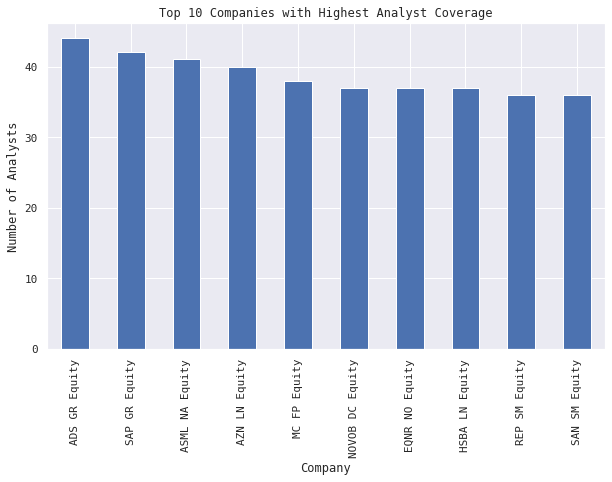

The company with the highest analyst coverage is 'ADS GR Equity' with 44 analysts covering it.


In [30]:
# Calculate the analyst coverage for each company
df_coverage = df_clean[['BBTICKER', 'ANALYST']].copy()
df_coverage = df_coverage.drop_duplicates()
company_coverage = df_coverage['BBTICKER'].value_counts()

# Plot the top 10 companies with the highest analyst coverage
top_10_company_coverage = company_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_company_coverage.plot(kind='bar')
plt.title('Top 10 Companies with Highest Analyst Coverage')
plt.xlabel('Company')
plt.ylabel('Number of Analysts')
plt.show()

# Find the company with the highest analyst coverage
most_covered_company = company_coverage.idxmax()
most_covered_company_coverage = company_coverage.max()

print(f"The company with the highest analyst coverage is '{most_covered_company}' with {most_covered_company_coverage} analysts covering it.")


## 2. Which analyst covers the most companies?

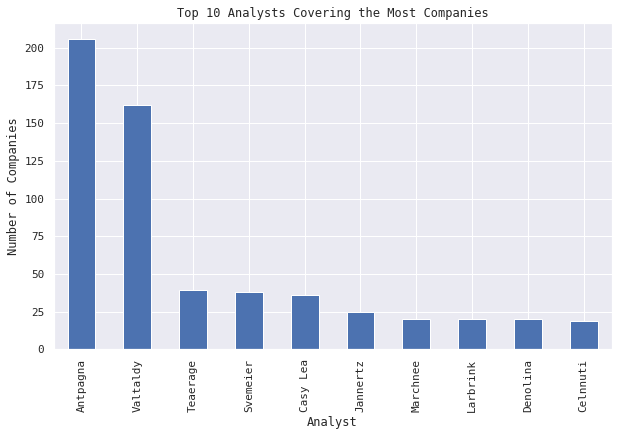

The analyst who covers the most companies is 'Antpagna' covering 206 different companies.


In [5]:
# Calculate the number of companies each analyst covers
# analyst_coverage = df.groupby('ANALYST')['BBTICKER'].nunique()
analyst_coverage = df_coverage['ANALYST'].value_counts()

# Plot the top 10 analysts covering the most companies
# top_10_analyst_coverage = analyst_coverage.sort_values(ascending=False).head(10)
top_10_analyst_coverage = analyst_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_analyst_coverage.plot(kind='bar')

plt.title('Top 10 Analysts Covering the Most Companies')
plt.xlabel('Analyst')
plt.ylabel('Number of Companies')
plt.show()

# Find the analyst covering the most companies
most_companies_analyst = analyst_coverage.idxmax()
most_companies_coverage = analyst_coverage.max()

print(f"The analyst who covers the most companies is '{most_companies_analyst}' covering {most_companies_coverage} different companies.")


## 3. Similarity Matrix
https://medium.com/analytics-vidhya/similarity-measures-for-categorical-data-d83a1812bbe9

Based on how analysts organize themselves into covering companies,
### a. Could you model the similarity or conversely, the distance matrix between the companies based on this analyst co-coverage


In [31]:
df_company_info_broker = df_clean[['BBTICKER', 'GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME', 'BROKER']].groupby(['BBTICKER', 'GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME'], as_index = False).size().copy()
df_company_info_rating = df_clean[['BBTICKER', 'GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME', 'RATING']].groupby(['BBTICKER', 'GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME'], as_index = False).mean().copy()
df_company_info = df_company_info_broker.merge(df_company_info_rating, on=['BBTICKER', 'GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME'])
df_company_info

,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME,size,RATING
0,1COV GR Equity,Materials,Materials,28,3.750000
1,AAL LN Equity,Materials,Materials,28,3.812738
2,ABBN SW Equity,Industrials,Capital Goods,35,3.489446
3,ABF LN Equity,Consumer Staples,"Food, Beverage & Tobacco",26,4.369304
4,ABI BB Equity,Consumer Staples,"Food, Beverage & Tobacco",36,3.694444
...,...,...,...,...,...
355,WPP LN Equity,Communication Services,Media & Entertainment,28,3.770400
356,WRT1V FH Equity,Industrials,Capital Goods,21,3.095238
357,WTB LN Equity,Consumer Discretionary,Consumer Services,28,2.714286
358,YAR NO Equity,Materials,Materials,25,3.960000


In [32]:
categorical_features_ordinal = []
categorical_features_one_hot = ['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']
numerical_features = []
clean_pipeline = get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)

# We only want to observe analyst 'Antpagna'
# We also clean the dataset 
## -- Categorical features: One_hot/Ordinal encoding 

df_analyst_antpaga = df_clean[df_clean["ANALYST"] == "Antpagna"].copy()

# Remove duplicates
df_analyst_antpaga = df_analyst_antpaga.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

df_company_info_antaga = df_company_info[df_company_info["BBTICKER"].isin(df_analyst_antpaga['BBTICKER'].tolist())]
df_preprocessed = clean_pipeline.fit_transform(df_company_info_antaga.copy())
cols = df_analyst_antpaga["BBTICKER"].tolist().copy()


##### (i) Using Eskin to get similarity matrx
The Eskin similarity measure was proposed by Eskin et al. (2002). It is constructed to assign higher weights to mismatches on variables with more categories

Definition: Sₖ(Xₖ,Yₖ)=1 if Xₖ = Yₖ and equal to nₖ²/(nₖ²+2) otherwise and the weight wₖ is 1/d here k =1,2,….d




Shape of the similarity matrix: (206, 206)


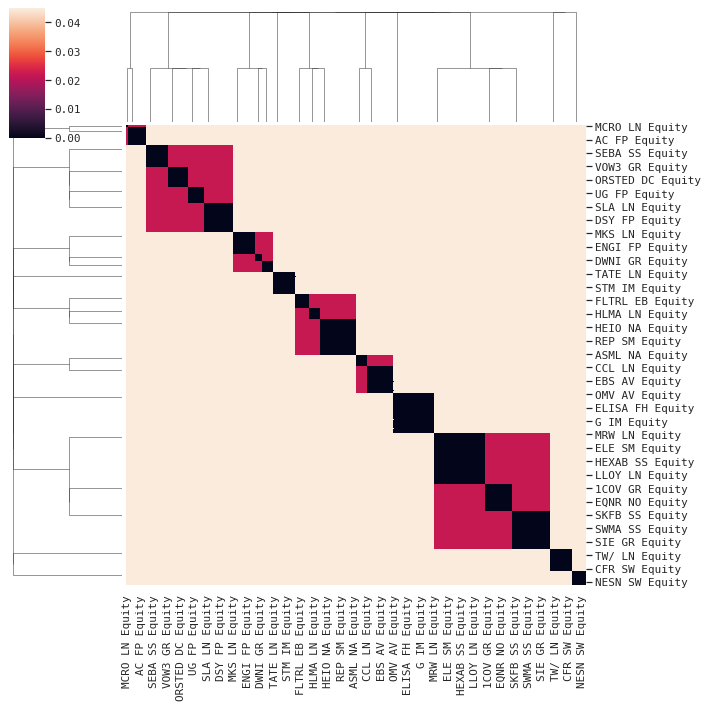

In [33]:
df_preprocessed_sim = pd.DataFrame(data = Eskin(df_preprocessed),  
                                   index = cols, columns = cols)
print("Shape of the similarity matrix:", df_preprocessed_sim.shape)
linkage = hc.linkage(sp.distance.squareform(df_preprocessed_sim), method='average')
sns.clustermap(df_preprocessed_sim, row_linkage=linkage, col_linkage=linkage)

##### (ii) Using IOF-Inverse Occurrence Frequency to get similarity matrx
The IOF measure assigns higher weight to mismatches on less frequent values and vice versa.

Definition : 1/(1+log(fₖ(Xₖ))*log(fₖ(Yₖ))) otherwise and the weight wₖ is 1/d here k =1,2,….d

Shape of the similarity matrix: (206, 206)


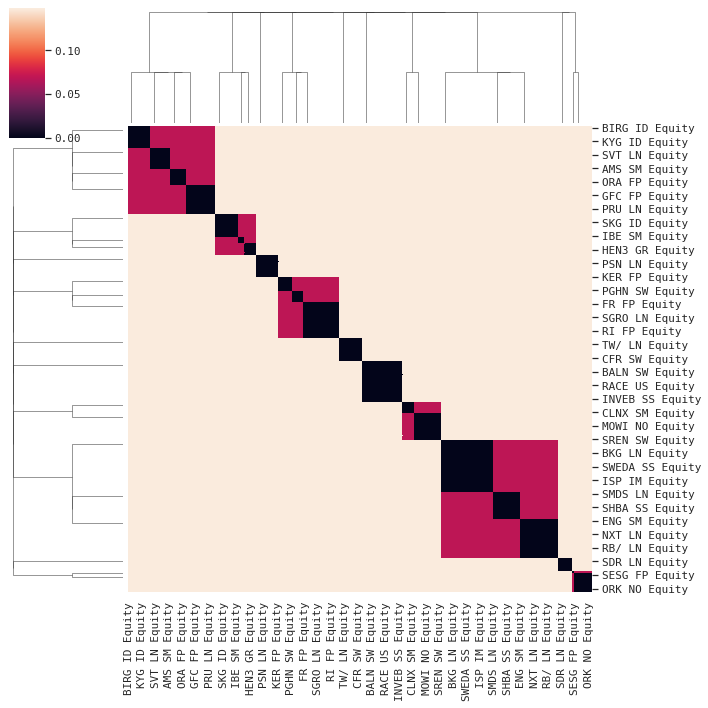

In [35]:
df_preprocessed_sim = pd.DataFrame(data = IOF(df_preprocessed),  
                                   index = cols, columns = cols)
print("Shape of the similarity matrix:", df_preprocessed_sim.shape)
linkage = hc.linkage(sp.distance.squareform(df_preprocessed_sim), method='average')
sns.clustermap(df_preprocessed_sim, row_linkage=linkage, col_linkage=linkage)

Shape of the similarity matrix: (360, 360)


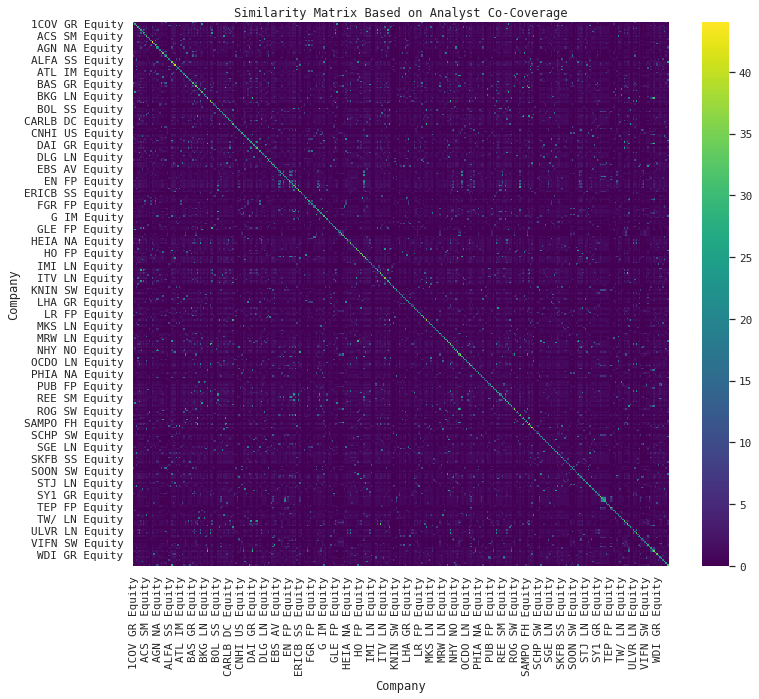

In [44]:
# Create a pivot table where rows are analysts and columns are companies
pivot_table = df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix (dot product of pivot table with its transpose)
similarity_matrix = np.dot(pivot_table.T, pivot_table)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=pivot_table.columns, columns=pivot_table.columns)
similarity_df
# Print the shape of the similarity matrix
print("Shape of the similarity matrix:", similarity_df.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst Co-Coverage')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


### b. How would the results change if you were to restrict the dataset to only analysts having companies covered within 1s.d. of the distribution found in Qn. 2?

The analyst with the most coverage after filtering: DanCosta

Shape of the similarity matrix: (12, 12)


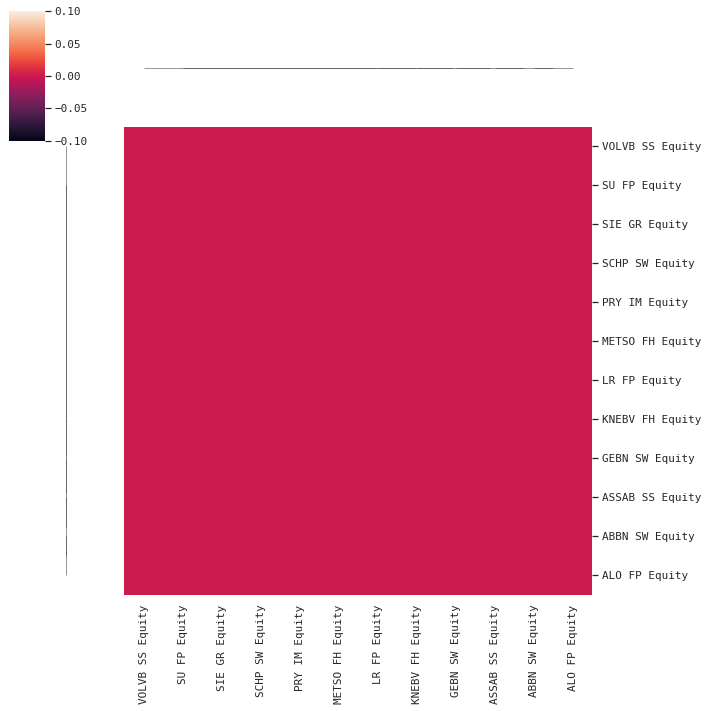

In [34]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index
filtered_df = df_clean[df_clean['ANALYST'].isin(filtered_analysts)].copy()

# Now, we find the analyst with the most coverage
filtered_df_analyst_coverage = filtered_df['ANALYST'].value_counts()
filtered_highest_analyst = filtered_df_analyst_coverage.head(1).index[0]
print("The analyst with the most coverage after filtering: " + filtered_highest_analyst)
print()

# Then, find the rows covered by analyst
df_analyst = df_clean[df_clean["ANALYST"] == filtered_highest_analyst].copy()
# Remove duplicates
df_analyst = df_analyst.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

df_company_info_analyst = df_company_info[df_company_info["BBTICKER"].isin(df_analyst['BBTICKER'].tolist())]
df_preprocessed = clean_pipeline.fit_transform(df_company_info_analyst.copy())
cols = df_company_info_analyst["BBTICKER"].tolist().copy()

df_preprocessed_sim = pd.DataFrame(data = Eskin(df_preprocessed),  
                                   index = cols, columns = cols)
print("Shape of the similarity matrix:", df_preprocessed_sim.shape)
linkage = hc.linkage(sp.distance.squareform(df_preprocessed_sim), method='average')
sns.clustermap(df_preprocessed_sim, row_linkage=linkage, col_linkage=linkage)

Shape of the filtered similarity matrix: (360, 360)


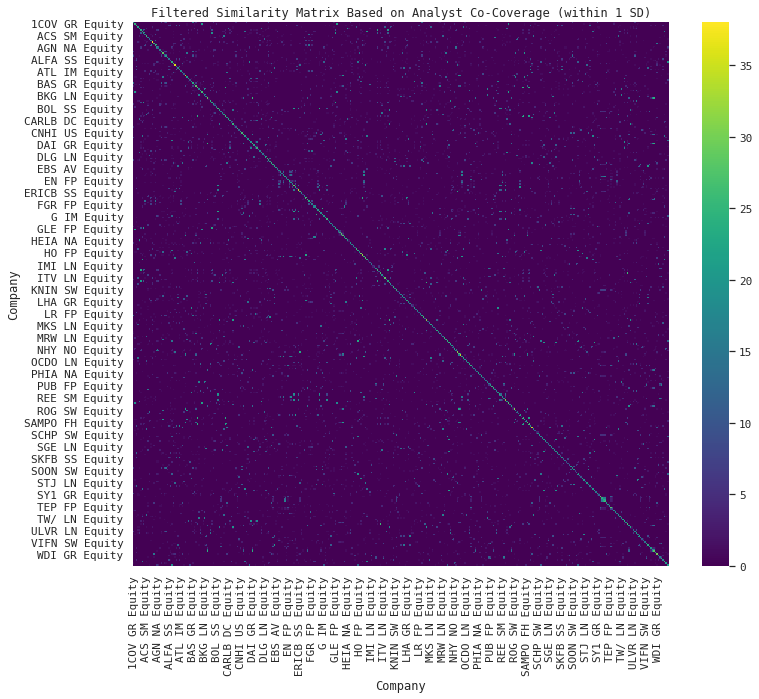

In [64]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index

# Filter the dataframe to only include the filtered analysts
filtered_df = df[df['ANALYST'].isin(filtered_analysts)]

# Create a pivot table for the filtered analysts
filtered_pivot_table = filtered_df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix for the filtered data
filtered_similarity_matrix = np.dot(filtered_pivot_table.T, filtered_pivot_table)

# Convert to DataFrame for better visualization
filtered_similarity_df = pd.DataFrame(filtered_similarity_matrix, index=filtered_pivot_table.columns, columns=filtered_pivot_table.columns)

# Print the shape of the filtered similarity matrix
print("Shape of the filtered similarity matrix:", filtered_similarity_df.shape)

# Plot the filtered similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_similarity_df, cmap='viridis')
plt.title('Filtered Similarity Matrix Based on Analyst Co-Coverage (within 1 SD)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


### c. If further restricted to a smaller subset?

For this example, let's further restrict the dataset by only choosing analysts within 0.25 s.d of the mean 

The analyst with the most coverage after filtering: KazAndac

Shape of the similarity matrix: (11, 11)


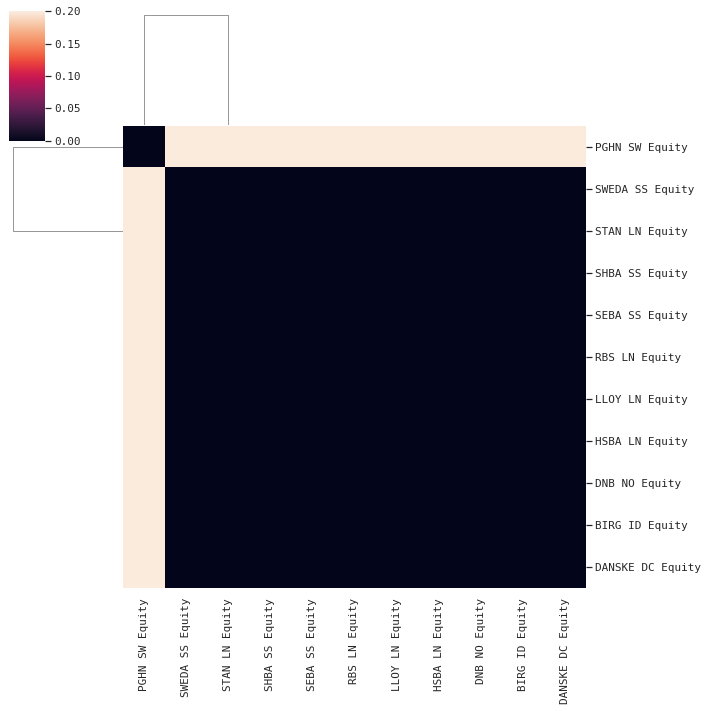

In [37]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage * 0.25) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage * 0.25)].index
filtered_df = df_clean[df_clean['ANALYST'].isin(filtered_analysts)].copy()

# Now, we find the analyst with the most coverage
filtered_df_analyst_coverage = filtered_df['ANALYST'].value_counts()
filtered_highest_analyst = filtered_df_analyst_coverage.head(1).index[0]
print("The analyst with the most coverage after filtering: " + filtered_highest_analyst)
print()

# Then, find the rows covered by analyst
df_analyst = df_clean[df_clean["ANALYST"] == filtered_highest_analyst].copy()
# Remove duplicates
df_analyst = df_analyst.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

df_company_info_analyst = df_company_info[df_company_info["BBTICKER"].isin(df_analyst['BBTICKER'].tolist())]
df_preprocessed = clean_pipeline.fit_transform(df_company_info_analyst.copy())
cols = df_company_info_analyst["BBTICKER"].tolist().copy()

df_preprocessed_sim = pd.DataFrame(data = Eskin(df_preprocessed),  
                                   index = cols, columns = cols)
print("Shape of the similarity matrix:", df_preprocessed_sim.shape)
linkage = hc.linkage(sp.distance.squareform(df_preprocessed_sim), method='average')
sns.clustermap(df_preprocessed_sim, row_linkage=linkage, col_linkage=linkage)

Shape of the selected similarity matrix: (18, 18)


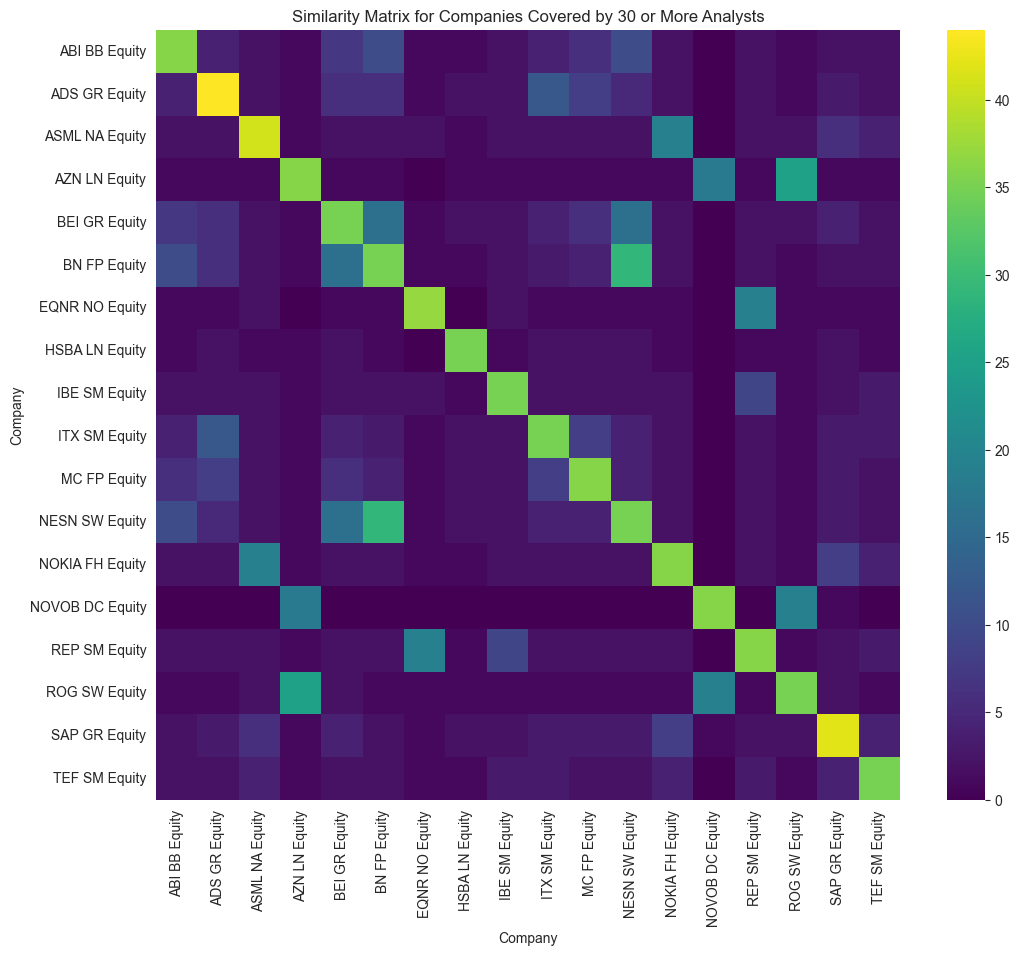

In [13]:
# Filter companies covered by 35 or more analysts
company_coverage = df['BBTICKER'].value_counts()
selected_companies = company_coverage[company_coverage >= 35].index

# Filter the dataframe to only include the selected companies
selected_df = df[df['BBTICKER'].isin(selected_companies)]

# Create a pivot table for the selected companies
selected_pivot_table = selected_df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix for the selected companies
selected_similarity_matrix = np.dot(selected_pivot_table.T, selected_pivot_table)

# Convert to DataFrame for better visualization
selected_similarity_df = pd.DataFrame(selected_similarity_matrix, index=selected_pivot_table.columns, columns=selected_pivot_table.columns)

# Print the shape of the selected similarity matrix
print("Shape of the selected similarity matrix:", selected_similarity_df.shape)

# Plot the selected similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(selected_similarity_df, cmap='viridis')
plt.title('Similarity Matrix for Companies Covered by 30 or More Analysts')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


# 4. Which sectors are the most heterogenous? (Look at the clusters formed by industry groups per sector – use t-SNE to visualize)

In [115]:
categorical_features_ordinal = []
categorical_features_one_hot = ['GICS_SECTOR_NAME', 'RECOMMENDATION', 'ANALYST', 'BBTICKER']
numerical_features = ['RATING', 'TARGET_PRICE']
clean_pipeline = get_pipeline_clean_encode_impute(categorical_features_one_hot, categorical_features_ordinal, numerical_features)

df_preprocessed = clean_pipeline.fit_transform(df.copy())
cols = df["GICS_INDUSTRY_GROUP_NAME"].tolist().copy()

In [119]:
df_preprocessed

,GICS_SECTOR_NAME_Communication Services,GICS_SECTOR_NAME_Consumer Discretionary,GICS_SECTOR_NAME_Consumer Staples,GICS_SECTOR_NAME_Energy,GICS_SECTOR_NAME_Financials,GICS_SECTOR_NAME_Health Care,GICS_SECTOR_NAME_Industrials,GICS_SECTOR_NAME_Information Technology,GICS_SECTOR_NAME_Materials,GICS_SECTOR_NAME_Real Estate,...,BBTICKER_WDI GR Equity,BBTICKER_WEIR LN Equity,BBTICKER_WKL NA Equity,BBTICKER_WPP LN Equity,BBTICKER_WRT1V FH Equity,BBTICKER_WTB LN Equity,BBTICKER_YAR NO Equity,BBTICKER_ZURN SW Equity,RATING,TARGET_PRICE
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,1.220000e+02
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,1.050000e+02
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,1.050000e+02
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,1.070000e+02
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,-2.420000e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8671,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,-2.420000e-14
8672,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,8.800000e+01
8673,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,8.900000e+01
8674,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,5.000000e+01


In [117]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(df_preprocessed)
tsne.kl_divergence_

0.5844376087188721

In [118]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=cols)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [79]:
X_tsne[:, 0].shape

(206,)